**MNIST/SVHN - DOMAIN ADAPTATION <br>
(version KERAS)**
---
PROJET COMPUTER VISION

In [34]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image


 ## MNIST dataset

The mnist dataset provided in python contains 70 000 labelled images of handwritten digits (possible labels: from 0 to 9), with 60 000 training examples and 10 000 test examples. Each example is an image represented by a matrix of size an array of 784 elements (this is the flattened version of the 28x28 image).

In [35]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

# print directories in dataset
print('train_dataset structure',dir(train_dataset))

# Data Loader (Input Pipeline)
bs = 100 # batch size
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

train_dataset structure ['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']


In [36]:
# DATASET STRUCTURE
print('train_dataset length:',len(train_dataset),type(train_dataset))
print('test_dataset length:',len(test_dataset),type(test_dataset))
print('images shape:',train_dataset[0][0].shape, type(train_dataset[0][0]))
labels = torch.unique(train_dataset.targets)
print('labels:', labels,type(train_dataset[0][1]))

train_dataset length: 60000 <class 'torchvision.datasets.mnist.MNIST'>
test_dataset length: 10000 <class 'torchvision.datasets.mnist.MNIST'>
images shape: torch.Size([1, 28, 28]) <class 'torch.Tensor'>
labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) <class 'int'>


**0/ Data exploration of MNIST and SVHN (numpy arrays)**
---

In [37]:
##################################################################
# DOWNLOADING DATA AND RESCALING SVHN TO MNIST SIZE
################################################################## 

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from PIL import Image

# Load MNIST data
#------------------------------------------

# Xs ans Ys as X and Y from source domain
(Xs_train, Ys_train), (Xs_test, Ys_test) = mnist.load_data()

# Flatten and normalize the image data and convert labels to categorical (one-hot encoding)
Xs_train = Xs_train.astype('float32') / 255
Xs_test = Xs_test.astype('float32') / 255
Ys_train_cat = to_categorical(Ys_train, num_classes=10)
Ys_test_cat = to_categorical(Ys_test, num_classes=10)

# Load SVHN data
#------------------------------------------

# Load the SVHN dataset directly as NumPy arrays
svhn_train, svhn_test = tfds.as_numpy(tfds.load('svhn_cropped', split=['train', 'test'], batch_size=-1, as_supervised=True))

# Extract images and labels
Xt_train, Yt_train = svhn_train
Xt_test, Yt_test = svhn_test

def preprocess_svhn_np(image):
    '''Function to resize and convert a single image to grayscale.
    Input: image of size 32x32x3 (HxWxC) in NumPy array format.
    Output: image of size 28x28, as a NumPy array.''' 
    image_pil = Image.fromarray(image)  # Convert to PIL Image for processing
    image_gray = image_pil.convert("L") # Convert to grayscale   
    image_resized = image_gray.resize((28, 28), Image.Resampling.LANCZOS) # Resize to 28x28
    image_np = np.array(image_resized, dtype=np.float32) / 255.0 # Convert back to NumPy array and normalize
    return image_np  # Ensure the shape is (28, 28)

# Applying the preprocessing function to each image in X_train
Xt_train = np.array([preprocess_svhn_np(image) for image in Xt_train])
Xt_test = np.array([preprocess_svhn_np(image) for image in Xt_test])

# Convert labels to one-hot encoding
Yt_train_cat = to_categorical(Yt_train, num_classes=10)
Yt_test_cat = to_categorical(Yt_test, num_classes=10)

# Check dimensions before training
print('Xs_train _test:',Xs_train.shape,Xs_test.shape ,type(Xs_train))
print('Ys_train _test:',Ys_train_cat.shape,Ys_test_cat.shape, type(Ys_train))
print('Xt_train _test:',Xt_train.shape,Xt_test.shape, type(Xt_train)) 
print('Yt_train _test:',Yt_train_cat.shape,Yt_test_cat.shape, type(Yt_train))

Xs_train _test: (60000, 28, 28) (10000, 28, 28) <class 'numpy.ndarray'>
Ys_train _test: (60000, 10) (10000, 10) <class 'numpy.ndarray'>
Xt_train _test: (73257, 28, 28) (26032, 28, 28) <class 'numpy.ndarray'>
Yt_train _test: (73257, 10) (26032, 10) <class 'numpy.ndarray'>


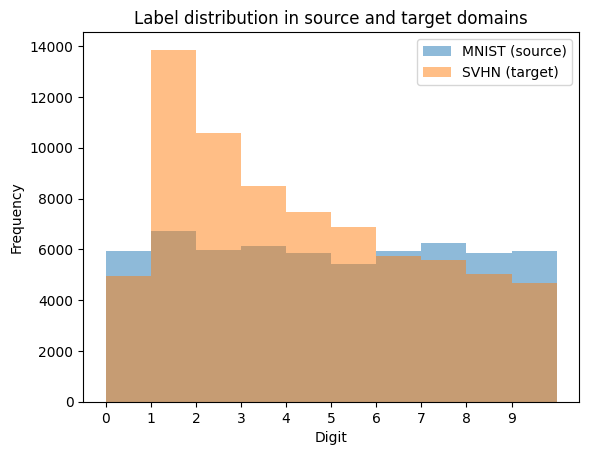

weights_source: [10.1  8.9 10.1  9.8 10.3 11.1 10.1  9.6 10.3 10.1]
weights_target (for information only): [14.8  5.3  6.9  8.6  9.8 10.6 12.8 13.1 14.5 15.7]


In [38]:
#######################################################
# CHECKING DISTRIBUTION OF LABELS IN SOURCE AND TARGET
#######################################################

# Plotting the distribution of labels in the source and target domains
plt.hist(Ys_train, bins=range(11), alpha=0.5, label='MNIST (source)')
plt.hist(Yt_train, bins=range(11), alpha=0.5, label='SVHN (target)')
plt.xlabel('Digit')
plt.xticks(range(10))
plt.ylabel('Frequency')
plt.legend()
plt.title('Label distribution in source and target domains')
plt.show()

# calculating the weights for the loss function
# MNIST (source domain)
label_frequency_source = np.bincount(Ys_train) / len(Ys_train)
weights_source = 1 / label_frequency_source
print('weights_source:',np.round(weights_source,1))
# SVHN (target domain)
label_frequency_target = np.bincount(Yt_train) / len(Yt_train)
weights_target = 1 / label_frequency_target
print('weights_target (for information only):',np.round(weights_target,1))

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# target domain is very imbalanced, HOWEVER we are not supposed to know the labels of the target domain
# 1/ GAN does not deal with this
# 2/ semi-supervised GAN (with pseudo labels on SVHN when high confidence) will adress this issue

In [39]:
# number of samples per label in the test set
print('Ys_test:',np.bincount(Ys_test), 'total', len(Ys_test))
print('Yt_test:',np.bincount(Yt_test), 'total', len(Yt_test))

Ys_test: [ 980 1135 1032 1010  982  892  958 1028  974 1009] total 10000
Yt_test: [1744 5099 4149 2882 2523 2384 1977 2019 1660 1595] total 26032


**1/ ADVERSARIAL NEURAL NETWORK (KERAS), downsizing SVHN to MNIST dimensions (28,28,)**
---
"Domain-Adversarial Training of Neural Networks" Ganin & al, Journal of Machine Learning Research 17 (2016) 1-35

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy , CategoricalCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds

In [41]:
def extract_X_Y(dataset):
    """
    Extracts features and labels from an unbatched TensorFlow dataset.
    
    Parameters:
    - dataset: A tf.data.Dataset object containing (features, labels) pairs.
    
    Returns:
    - X: A tensor containing all the features from the dataset.
    - Y: A tensor containing all the labels from the dataset.
    """
    # Initialize lists to hold the features and labels
    features_list = []
    labels_list = []

    # Iterate over the dataset to collect features and labels
    for features, labels in dataset:
        features_list.append(features.numpy())
        labels_list.append(labels.numpy())

    # Convert lists to numpy arrays
    features_array = np.array(features_list)
    labels_array = np.array(labels_list)

    # Convert numpy arrays to tensors
    Xt = tf.convert_to_tensor(features_array, dtype=tf.float32)
    Yt = tf.convert_to_tensor(labels_array, dtype=tf.int64)

    return Xt, Yt


In [42]:
##################################################################
# DOWNLOADING DATA AND RESCALING SVHN TO MNIST SIZE
################################################################## 

#------------------------------------------
# Define batch size
#------------------------------------------
batch_size = 32

#------------------------------------------
# Load MNIST data
#------------------------------------------

# Load MNIST data (source)  as tensors
mnist_train, mnist_test = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

# Round number of samples
mnist_train = mnist_train.take((len(mnist_train) // batch_size) * batch_size) # round to facilitate division by batch size
mnist_test = mnist_test.take((len(mnist_test) // batch_size) * batch_size) 

# Define a preprocessing function for MNIST data
def preprocess_mnist_tensor(image, label):
    """Function to normalize MNIST images and convert labels to one-hot.
    Input: image tensor, label tensor.
    Output: Normalized image tensor, one-hot encoded label tensor."""
    image = tf.cast(image, tf.float32) / 255.0  # Normalize images
    #image = tf.expand_dims(image, -1)  # Ensure image has 3 dimensions
    #label = tf.one_hot(label, depth=10)  # One-hot encode labels
    return image, label

# Apply preprocessing to MNIST datasets
mnist_train = mnist_train.map(preprocess_mnist_tensor)
mnist_test = mnist_test.map(preprocess_mnist_tensor)

# Extract images and labels
Xs_train, Ys_train = extract_X_Y(mnist_train)
Xs_test, Ys_test = extract_X_Y(mnist_test)

#------------------------------------------
# Load SVHN data
#------------------------------------------

# Load SVHN data as TensorFlow datasets
svhn_train, svhn_test = tfds.load('svhn_cropped', split=['train', 'test'], as_supervised=True)

# Round number of samples
svhn_train = svhn_train.take((len(svhn_train) // batch_size) * batch_size) # round to facilitate division by batch size
svhn_test = svhn_test.take((len(svhn_test) // batch_size) * batch_size) 

def preprocess_svhn_tensor(image, label):
    """Function to resize and convert a tensor image to grayscale, and normalize it.
    Input: image tensor of size 32x32x3, label.
    Output: Preprocessed image tensor of size 28x28x1, label."""
    image_resized = tf.image.resize(image, [28, 28])  # Resize to 28x28x3
    image_gray = tf.image.rgb_to_grayscale(image_resized)  # Convert to grayscale
    image_normalized = image_gray / 255.0  # Normalize
    return image_normalized, label

# Apply preprocessing to SVHN datasets
svhn_train = svhn_train.map(preprocess_svhn_tensor)
svhn_test = svhn_test.map(preprocess_svhn_tensor)

# Extract images and labels
Xt_train, Yt_train = extract_X_Y(svhn_train)
Xt_test, Yt_test = extract_X_Y(svhn_test)

# Convert Y labels to one-hot encoding 
Ys_train_cat = to_categorical(Ys_train, num_classes=10)
Ys_test_cat = to_categorical(Ys_test, num_classes=10)
Yt_train_cat = to_categorical(Yt_train, num_classes=10)
Yt_test_cat = to_categorical(Yt_test, num_classes=10)


# Check dimensions before training
print('Xs_train _test:',Xs_train.shape,Xs_test.shape ,type(Xs_train))
print('Ys_train_cat _test_cat:',Ys_train_cat.shape,Ys_test_cat.shape, type(Ys_train))
print('Xt_train _test:',Xt_train.shape,Xt_test.shape, type(Xt_train)) 
print('Yt_train _test:',Yt_train_cat.shape,Yt_test_cat.shape, type(Yt_train))

Xs_train _test: (60000, 28, 28, 1) (9984, 28, 28, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>
Ys_train_cat _test_cat: (60000, 10) (9984, 10) <class 'tensorflow.python.framework.ops.EagerTensor'>
Xt_train _test: (73248, 28, 28, 1) (26016, 28, 28, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>
Yt_train _test: (73248, 10) (26016, 10) <class 'tensorflow.python.framework.ops.EagerTensor'>


In [43]:
#######################################################
# CHECKING DISTRIBUTION OF LABELS IN SOURCE AND TARGET
#######################################################

#------------------------------------------
# MNIST (source domain)
#------------------------------------------

# Calculate the unique labels and their counts
labels, _, counts = tf.unique_with_counts(tf.reshape(Ys_train, [-1]))
print('labels:', labels.numpy())
# Calculate label frequencies as a float
label_frequency_source = tf.cast(counts, tf.float32) / tf.size(Ys_train, out_type=tf.float32)

# Calculate weights as the inverse of frequencies
weights_source = 1.0 / label_frequency_source

# Since TensorFlow operations do not return numpy arrays directly, use .numpy() to print
print('weights_source:', np.round(weights_source.numpy(), 1))
print('weights_source dimensions:', weights_source.shape)
print('weights_source values:', weights_source.numpy())
#------------------------------------------
# SVHN (target domain) - must not be used at this stage
#------------------------------------------


labels: [4 1 0 7 8 2 6 3 9 5]
weights_source: [10.3  8.9 10.1  9.6 10.3 10.1 10.1  9.8 10.1 11.1]
weights_source dimensions: (10,)
weights_source values: [10.270455   8.899436  10.130001   9.577015  10.254658  10.070494
 10.13856    9.786331  10.085729  11.0680685]


In [44]:
##################################################################
#     CREATING DATASETS FOR THE GANN (MNIST+SVHN)
##################################################################

import tensorflow as tf

# Assuming Xs_train, Xt_train, Ys_train, and Yt_train are all TensorFlow tensors
# If not, you can convert them like so:
# Xs_train = tf.convert_to_tensor(Xs_train, dtype=tf.float32)
# Xt_train = tf.convert_to_tensor(Xt_train, dtype=tf.float32)
# Ys_train = tf.convert_to_tensor(Ys_train, dtype=tf.int32)
# Yt_train = tf.convert_to_tensor(Yt_train, dtype=tf.int32)

# 1. Concatenate MNIST and SVHN images
X_train = tf.concat([Xs_train, Xt_train], axis=0)

# 2. Create main task labels, with dummy labels for SVHN
Y_main_task_mnist = tf.one_hot(Ys_train, depth=10)
Y_main_task_svhn = tf.zeros([tf.shape(Yt_train)[0], 10], dtype=tf.float32)  # Dummy labels for SVHN
Y_main_task = tf.concat([Y_main_task_mnist, Y_main_task_svhn], axis=0)

# 3. Create adversary labels (0 for MNIST, 1 for SVHN)
Y_adversary = tf.concat([tf.zeros(tf.shape(Ys_train)[0]), tf.ones(tf.shape(Yt_train)[0])], axis=0)

# 4. Shuffle the combined dataset to ensure mixed samples of both domains
# Create an index tensor and shuffle it
indices = tf.range(start=0, limit=tf.shape(X_train)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

# Use the shuffled indices to reorder the dataset
X_train = tf.gather(X_train, shuffled_indices)
Y_main_task = tf.gather(Y_main_task, shuffled_indices)
Y_adversary = tf.gather(Y_adversary, shuffled_indices)

# Print shapes
print('Shapes X_train:', X_train.shape)
print('Shapes Y_main_task (one hot encoded):', Y_main_task.shape)
print('Shape Y_adversary_task (binary):', Y_adversary.shape)

Shapes X_train: (133248, 28, 28, 1)
Shapes Y_main_task (one hot encoded): (133248, 10)
Shape Y_adversary_task (binary): (133248,)


In [45]:
################################################################
#  CREATE BATCHED DATASETS ON X_train, Y_main_task, Y_adversary
################################################################

# Create a TensorFlow dataset from the tensors
dataset = tf.data.Dataset.from_tensor_slices((X_train, {"main_task_output": Y_main_task, "adversarial_output": Y_adversary}))

# Batch the dataset
dataset = dataset.batch(batch_size)

# Optional: Add .prefetch to improve performance by overlapping the preprocessing and model execution of a batch
# For example, .prefetch(tf.data.AUTOTUNE) allows the dataset to automatically tune the prefetch buffer size
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [46]:
#####################################################
# GRL - Gradient Reversal Layer
# creation of a custom layer in keras
#####################################################

class GradientReversalLayer(Layer):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs, **kwargs):
        @tf.custom_gradient
        def grad_reverse(x):
            identity = tf.identity(x)
            
            def custom_grad(dy):
                return -dy * self.alpha
            
            return identity, custom_grad
        
        return grad_reverse(inputs)
    
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy



In [47]:
#################################################################
#       TRAINING A SIMPLIST GAN (image size 28x28)
# inspired by the classical LeNet-5 (LeCun et al., 1998)
#################################################################

#from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# define input dimension
input_dim = (28,28,1)

# Input layer
input_layer = Input(shape=(input_dim))

# Deep feature extractor = features f
feature_extractor = Conv2D(32, (5, 5), activation='relu', input_shape=(28,28,1))(input_layer)  #size (24,24,32)
feature_extractor = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(feature_extractor)          #size (12,12,32)
feature_extractor = Conv2D(48, (5, 5), activation='relu')(feature_extractor)                   #size (8,8,48)
feature_extractor = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(feature_extractor)          #size (4,4,48)
extracted_features = Flatten()(feature_extractor)                                              #size 768

# Label predictor (Main task classifier layers)
# multi-class classification (10 classes from 0 to 9)
main_task_hidden = Dense(100, activation='relu')(extracted_features)
main_task_hidden = Dense(100, activation='relu')(main_task_hidden)
main_task_output = Dense(10, activation='softmax', name='main_task_output')(main_task_hidden)

# Domain classifier (Adversarial component layers)
# binary classification (MNIST=0 and SVHN=1) 
gradient_reversal = GradientReversalLayer(alpha=0.0001)(extracted_features)
adversary_hidden = Dense(100, activation='relu')(gradient_reversal)
adversarial_output = Dense(1, activation='sigmoid', name='adversarial_output')(adversary_hidden)

# Model
model_GAN_28_28_1 = Model(inputs=input_layer, outputs=[main_task_output, adversarial_output])

'''# Loss functions (sub-optimal)
# dummy labels will pollute predictions of classe 0 and increase artificially loss on main tast
main_task_loss = CategoricalCrossentropy()
adversarial_loss = BinaryCrossentropy()
'''
# Compile the model
model_GAN_28_28_1.compile(optimizer=Adam(learning_rate=0.001),
              loss={'main_task_output': CategoricalCrossentropy(), # dummy labels will pollute predictions of classe 0 and increase artificially loss on main tast
                    'adversarial_output': BinaryCrossentropy()},
              #sample_weight={'main_task_output': weights_main_task, 'adversarial_output': np.ones(Y_adversary.shape[0])}, # weights for the SVHN samples not supposed to be known
              metrics={'main_task_output': ['accuracy'], 'adversarial_output': [AUC()]})

# % MNIST vs SVHN
print('% MNIST in sample (=adversarial target):',round(1 - np.mean(Y_adversary.numpy()),2))

# Train the model
history_28_28_1 = model_GAN_28_28_1.fit(X_train, 
                                        {'main_task_output': Y_main_task, 'adversarial_output': Y_adversary}, 
                                        epochs=3)

% MNIST in sample (=adversarial target): 0.45
Epoch 1/3
4164/4164 [==============================] - 40s 9ms/step - loss: 3202134784.0000 - main_task_output_loss: 3202134272.0000 - adversarial_output_loss: 103.8874 - main_task_output_accuracy: 0.1029 - adversarial_output_auc_1: 0.8655
Epoch 2/3
4164/4164 [==============================] - 39s 9ms/step - loss: 44730658816.0000 - main_task_output_loss: 44730658816.0000 - adversarial_output_loss: 15.3998 - main_task_output_accuracy: 0.1044 - adversarial_output_auc_1: 0.5151
Epoch 3/3
4164/4164 [==============================] - 38s 9ms/step - loss: 182583066624.0000 - main_task_output_loss: 182583066624.0000 - adversarial_output_loss: 4.8061 - main_task_output_accuracy: 0.1031 - adversarial_output_auc_1: 0.5076


In [48]:
'''!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
THE MODEL CANNOT LEARN PROPERPLY BECAUSE OF THE DUMMY LABELS IN THE ADVERSARIAL TASK
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'''

'!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\nTHE MODEL CANNOT LEARN PROPERPLY BECAUSE OF THE DUMMY LABELS IN THE ADVERSARIAL TASK\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'

Source test dataset scores: [809280536576.0, 809280536576.0, 0.8021178841590881, 0.09815704822540283, 0.0]
Accuracy on the main task (source): 9.82
Accuracy on the adversarial task (source): 100.0
Ys_test: [ 978 1133 1030 1009  980  888  958 1027  973 1008]


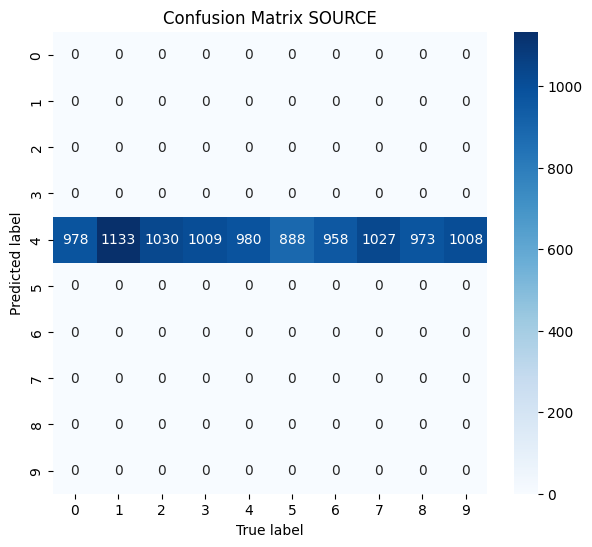

In [49]:
######################################################
# EVALUATE THE MODEL ON THE SOURCE TEST DATASET
######################################################

# Create a combined dataset for testing
Ys_test_adversary = np.zeros((Ys_test.shape[0], 1))  #(0 for MNIST and 1 for SVHN)
Ys_test_combined = np.concatenate([Ys_test_cat, Ys_test_adversary], axis=1)


# Make predictions on the source test set
pred_Ys_test_scores = model_GAN_28_28_1.evaluate(Xs_test,  {'main_task_output': Ys_test_cat, 'adversarial_output': Ys_test_adversary}, verbose=0)
print('Source test dataset scores:', pred_Ys_test_scores)

#Predictions
pred_Ys_test_probas, pred_Ys_test_probas_adversarial = model_GAN_28_28_1.predict(Xs_test, verbose=0)
pred_Ys_test = tf.argmax(pred_Ys_test_probas, axis=1)
pred_Ys_test_adversarial = tf.argmax(pred_Ys_test_probas_adversarial, axis=1)
#print('probas pred_Ys_test[0]:',pred_Ys_test[0])
#print('labels pred_Ys_test[:10]:',pred_Ys_test[:10],type(pred_Ys_test))

# Accuracy scores main and adversarial tasks
correct_pred_Ys_test = tf.cast(tf.equal(pred_Ys_test, Ys_test), tf.float32)
accuracy_source_main_task = tf.reduce_mean(correct_pred_Ys_test).numpy()
print('Accuracy on the main task (source):', round(accuracy_source_main_task*100, 2))

correct_pred_Ys_test_adversarial = tf.cast( tf.equal(pred_Ys_test_adversarial, Ys_test_adversary)   , tf.float32)
accuracy_source_adversarial = tf.reduce_mean(correct_pred_Ys_test_adversarial).numpy()
print('Accuracy on the adversarial task (source):', round(accuracy_source_adversarial*100, 2))

# Calculate the accuracy on the main task by label
confusion_mtx_28_source = tf.math.confusion_matrix(pred_Ys_test, Ys_test)

# print number of samples per label
print('Ys_test:',np.bincount(Ys_test))

# show confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mtx_28_source, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix SOURCE')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

**1/bis GANN (Keras) with combined label for custom loss function**
---

In [17]:
#################################################################
# Combining labels (Y_main_task) and domain labels (Y_adversary)
# Y_adversary is added as an 11th dimension to Y_main_task (onehot encoded)
#################################################################

# Convert Y_adversary to the same type as Y_main_task for concatenation
Y_adversary_float = tf.cast(Y_adversary, tf.float32)

# Expand dimensions of Y_adversary to match Y_main_task
Y_adversary_expanded = tf.expand_dims(Y_adversary_float, axis=-1)

# Concatenate Y_main_task with Y_adversary along the last dimension
Y_combined = tf.concat([Y_main_task, Y_adversary_expanded], axis=-1)
print('Y_combined shape:', Y_combined.shape)
print(tf.reduce_all(Y_combined[..., -1]==Y_adversary))

# Create a composite dataset with X_train and Y_combined
dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_combined)).batch(batch_size)


Y_combined shape: (133248, 11)
tf.Tensor(True, shape=(), dtype=bool)


In [18]:
#########################################################################
# CREATING A CUSTOM LOSS FUNCTION FOR THE MAIN AND ADVERSARIAL TASKS
#########################################################################

def custom_main_task_loss(y_true, y_pred):
    '''function unpacts the true labels for classification (10 first dimensions) 
    and the mask (11th dimension) from y_true which is the combined tensor of Y_main_task (label between 0 and 9)
    and Y_adversary (0 for MNIST and 1 for SVHN)
    Calculates the categorical crossentropy loss for the main task, considering only MNIST samples (where the mask is applied)'''
    # Unpack the true labels and the mask from y_true
    y_true_labels = y_true[..., :-1]  # All but the last dimension are true labels
    mask = 1 - y_true[..., -1]  # Last dimension is the mask
    
    # Calculate the categorical crossentropy loss
    cce = CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    unmasked_loss = cce(y_true_labels, y_pred)
    
    # Apply the mask
    masked_loss = unmasked_loss * mask
    
    # Compute the mean loss, considering only MNIST samples (where the mask is applied)
    return tf.reduce_sum(masked_loss) / tf.maximum(tf.reduce_sum(mask), 1)

def custom_adversarial_loss(y_true, y_pred):
    '''function unpacts the mask (11th dimension) from y_true which is the combined tensor of Y_main_task and Y_adversary
    Calculates the binary crossentropy loss for the adversarial task on all values (MNIST and SVHN)
    '''
    # Extract the adversarial labels (mask) from y_true
    adversarial_labels = y_true[..., -1]  # Last dimension after combining
    
    # Calculate the binary crossentropy loss for the adversarial task
    bce = BinaryCrossentropy(reduction=tf.keras.losses.Reduction.AUTO)
    loss = bce(adversarial_labels, y_pred)
    
    return loss


In [19]:
#################################################################
#       TRAINING A SIMPLIST GAN (image size 28x28)
# inspired by the classical LeNet-5 (LeCun et al., 1998)
#################################################################

#from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# define input dimension
input_dim = (28,28,1)

# Input layer
input_layer = Input(shape=(input_dim))

# Deep feature extractor = features f
feature_extractor = Conv2D(32, (5, 5), activation='relu', input_shape=(28,28,1))(input_layer)  #size (24,24,32)
feature_extractor = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(feature_extractor)          #size (12,12,32)
feature_extractor = Conv2D(48, (5, 5), activation='relu')(feature_extractor)                   #size (8,8,48)
feature_extractor = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(feature_extractor)          #size (4,4,48)
extracted_features = Flatten()(feature_extractor)                                              #size 768

# Label predictor (Main task classifier layers)
# multi-class classification (10 classes from 0 to 9)
main_task_hidden = Dense(100, activation='relu')(extracted_features)
main_task_hidden = Dense(100, activation='relu')(main_task_hidden)
main_task_output = Dense(10, activation='softmax', name='main_task_output')(main_task_hidden)

# Domain classifier (Adversarial component layers)
# binary classification (MNIST=0 and SVHN=1) 
gradient_reversal = GradientReversalLayer(alpha=0.01)(extracted_features)
adversary_hidden = Dense(100, activation='relu')(gradient_reversal)
adversarial_output = Dense(1, activation='sigmoid', name='adversarial_output')(adversary_hidden)

# Model
model_GAN_custom_loss = Model(inputs=input_layer, outputs=[main_task_output, adversarial_output])

# define early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='loss',  # Monitor the validation loss (change it to 'loss' if you're not using a validation set)
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # To display messages when the callback takes action
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

model_GAN_custom_loss.compile(optimizer='adam',
                  loss={'main_task_output': custom_main_task_loss,  # Categorical crossentropy loss on MNIST only (masked)
                        'adversarial_output': custom_adversarial_loss}, # Binary crossentropy loss on all samples
                  metrics={'main_task_output': ['accuracy'], 'adversarial_output': ['accuracy']}, #AUC() not supported in custom loss functions
                  #callbacks=[early_stopping_callback]
                  )

# % MNIST vs SVHN
print('% MNIST in sample (=adversarial targey):',round(1 - np.mean(Y_combined[:, -1].numpy()),2))
# Train the model
history_GAN_custom_loss = model_GAN_custom_loss.fit(X_train, Y_combined, batch_size=batch_size, epochs=10)
#RELOAD DATA DIRECTLY

% MNIST in sample (=adversarial targey): 0.45
Epoch 1/10
4164/4164 [==============================] - 36s 8ms/step - loss: 0.1348 - main_task_output_loss: 0.1278 - adversarial_output_loss: 0.0070 - main_task_output_accuracy: 0.4328 - adversarial_output_accuracy: 0.4597
Epoch 2/10
4164/4164 [==============================] - 38s 9ms/step - loss: 0.0477 - main_task_output_loss: 0.0474 - adversarial_output_loss: 2.3580e-04 - main_task_output_accuracy: 0.4438 - adversarial_output_accuracy: 0.4593
Epoch 3/10
4164/4164 [==============================] - 34s 8ms/step - loss: 0.0343 - main_task_output_loss: 0.0340 - adversarial_output_loss: 2.9308e-04 - main_task_output_accuracy: 0.4458 - adversarial_output_accuracy: 0.4594
Epoch 4/10
4164/4164 [==============================] - 33s 8ms/step - loss: 0.0255 - main_task_output_loss: 0.0252 - adversarial_output_loss: 3.4227e-04 - main_task_output_accuracy: 0.4468 - adversarial_output_accuracy: 0.4594
Epoch 5/10
4164/4164 [========================

In [20]:
# SAVE MODEL (IF NECESSARY)
model_GAN_custom_loss.save('model_GAN_custom_loss_10_epoches')

import pickle

# Save the history object to a pickle file
with open('history_GAN_custom_loss_10_epoches.pkl', 'wb') as file:
    pickle.dump(history_GAN_custom_loss.history, file)
    
# to reload the model
# model_GAN_custom_loss = tf.keras.models.load_model('model_GAN_custom_loss_10_epoches')


INFO:tensorflow:Assets written to: model_GAN_custom_loss_10_epoches/assets


INFO:tensorflow:Assets written to: model_GAN_custom_loss_10_epoches/assets


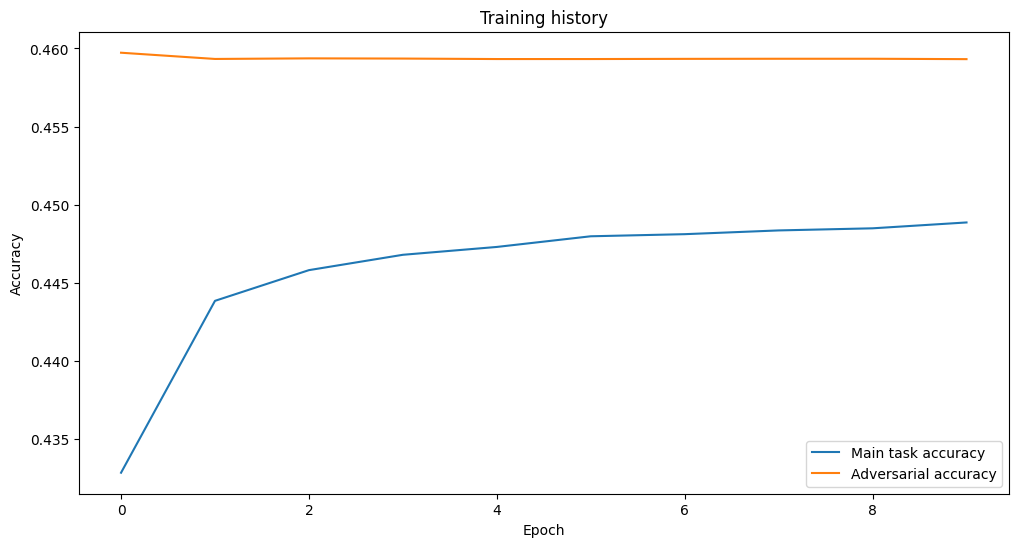

In [21]:
# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(history_GAN_custom_loss.history['main_task_output_accuracy'], label='Main task accuracy')
plt.plot(history_GAN_custom_loss.history['adversarial_output_accuracy'], label='Adversarial accuracy')
plt.title('Training history')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Source test dataset scores: [0.050008125603199005, 0.050008125603199005, 0.0, 0.9897836446762085, 0.9090887904167175]
Accuracy on the main task (source): 98.98
Accuracy on the adversarial task (source): 100.0
Ys_test: [ 978 1133 1030 1009  980  888  958 1027  973 1008]


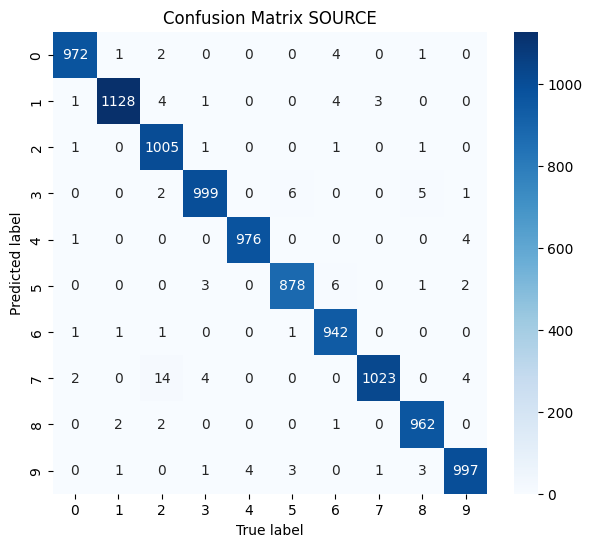

In [51]:
# EVALUATE THE MODEL

#--------------------------------------------------------------------
# Evaluate the model on the SOURCE test set
#--------------------------------------------------------------------

# Create a combined dataset for testing
Ys_test_adversary = np.zeros((Ys_test.shape[0], 1))  #(0 for MNIST and 1 for SVHN)
Ys_test_combined = np.concatenate([Ys_test_cat, Ys_test_adversary], axis=1)

# Make predictions on the source test set
pred_Ys_test_scores = model_GAN_custom_loss.evaluate(Xs_test, Ys_test_combined, verbose=0)
print('Source test dataset scores:', pred_Ys_test_scores)

#Predictions
pred_Ys_test_probas, pred_Ys_test_probas_adversarial = model_GAN_custom_loss.predict(Xs_test, verbose=0)
pred_Ys_test = tf.argmax(pred_Ys_test_probas, axis=1)
pred_Ys_test_adversarial = tf.argmax(pred_Ys_test_probas_adversarial, axis=1)
#print('probas pred_Ys_test[0]:',pred_Ys_test[0])
#print('labels pred_Ys_test[:10]:',pred_Ys_test[:10],type(pred_Ys_test))

# Accuracy scores main and adversarial tasks
correct_pred_Ys_test = tf.cast(tf.equal(pred_Ys_test, Ys_test), tf.float32)
accuracy_source_main_task = tf.reduce_mean(correct_pred_Ys_test).numpy()
print('Accuracy on the main task (source):', round(accuracy_source_main_task*100, 2))

correct_pred_Ys_test_adversarial = tf.cast( tf.equal(pred_Ys_test_adversarial, Ys_test_adversary)   , tf.float32)
accuracy_source_adversarial = tf.reduce_mean(correct_pred_Ys_test_adversarial).numpy()
print('Accuracy on the adversarial task (source):', round(accuracy_source_adversarial*100, 2))

# Calculate the accuracy on the main task by label
confusion_mtx_source = tf.math.confusion_matrix(pred_Ys_test, Ys_test)

# print number of samples per label
print('Ys_test:',np.bincount(Ys_test))

# show confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mtx_source, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix SOURCE')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [23]:
# print number of samples per label
print('Ys_test:',np.bincount(Ys_test))

Ys_test: [ 978 1133 1030 1009  980  888  958 1027  973 1008]


In [52]:
# EVALUTE THE MODEL

#--------------------------------------------------------------------
# Evaluate the model on the TARGET test set
#--------------------------------------------------------------------

# Create a combined dataset for testing
Yt_test_adversary = np.ones((Yt_test.shape[0], 1))  #(0 for MNIST and 1 for SVHN)
Yt_test_combined = np.concatenate([Yt_test_cat, Yt_test_adversary], axis=1)

# Make predictions on the source test set
pred_Yt_test_scores = model_GAN_custom_loss.evaluate(Xt_test, Yt_test_combined, verbose=0)
print('TARGET test dataset scores:', pred_Yt_test_scores)

#Predictions
pred_Yt_test_probas, pred_Yt_test_probas_adversarial = model_GAN_custom_loss.predict(Xt_test, verbose=0)
pred_Yt_test = tf.argmax(pred_Yt_test_probas, axis=1)
pred_Yt_test_adversarial = tf.argmax(pred_Yt_test_probas_adversarial, axis=1)
#print('probas pred_Yt_test[0]:',pred_Yt_test[0])
#print('labels pred_Yt_test[:10]:',pred_Yt_test[:10],type(pred_Yt_test))

# Accuracy scores main and adversarial tasks
correct_pred_Yt_test = tf.cast(tf.equal(pred_Yt_test, Yt_test), tf.float32)
accuracy_target_main_task = tf.reduce_mean(correct_pred_Yt_test).numpy()
print('Accuracy on the main task (target):', round(accuracy_target_main_task*100, 2))

correct_pred_Yt_test_adversarial_bool = tf.equal(pred_Yt_test_adversarial, Yt_test_adversary)
correct_pred_Yt_test_adversarial = tf.cast( correct_pred_Yt_test_adversarial_bool   , tf.float32)
accuracy_target_adversarial = tf.reduce_mean(correct_pred_Yt_test_adversarial).numpy()
print('Accuracy on the adversarial task (target):', round(accuracy_target_adversarial*100, 2))

# Calculate the accuracy on the main task by label
confusion_mtx_target = tf.math.confusion_matrix(pred_Yt_test, Yt_test)

# print number of samples per label
#print('Yt_test:',np.bincount(Yt_test))

# show confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mtx_target, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix TARGET')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

TARGET test dataset scores: [0.00254087895154953, 0.0, 0.00254087895154953, 0.1999923139810562, 0.18203851580619812]
Accuracy on the main task (target): 20.0


: 

: 

: 

**2/ RETRAINING THE GANN WITH PSEUDO LABEL**
---

In [25]:
#get speudo labels on target dataset with high confidence level

def generate_pseudo_labels(model, X_unlabeled, threshold=0.9):
    # Predict probabilities
    predictions = model.predict(X_unlabeled)[0]  # Assuming the main task output is the first output
    
    # Select predictions with max probability > threshold
    max_probs = np.max(predictions, axis=1)
    confident_indices = np.where(max_probs > threshold)[0]
    
    # Filter out confident predictions and corresponding labels
    X_confident = X_unlabeled[confident_indices]
    pseudo_labels = np.argmax(predictions[confident_indices], axis=1)
    
    return X_confident, pseudo_labels, confident_indices

In [26]:
import tensorflow as tf
import numpy as np

def generate_pseudo_labels(model, X_unlabeled, threshold=0.9):
    # Predict probabilities
    predictions = model.predict(X_unlabeled)[0]  # Assuming the main task output is the first output
    
    # Select predictions with max probability > threshold
    max_probs = np.max(predictions, axis=1)
    confident_indices = np.where(max_probs > threshold)[0]
    
    # Convert confident_indices to a TensorFlow tensor
    confident_indices_tf = tf.constant(confident_indices, dtype=tf.int32)
    
    # Use TensorFlow's tf.gather to select the confident samples and labels
    X_confident = tf.gather(X_unlabeled, confident_indices_tf)
    pseudo_labels = tf.gather(np.argmax(predictions, axis=1), confident_indices_tf)
    
    return X_confident, pseudo_labels, confident_indices


813/813 [==============================] - 5s 6ms/step
Accuracy on confident target samples: 100.0


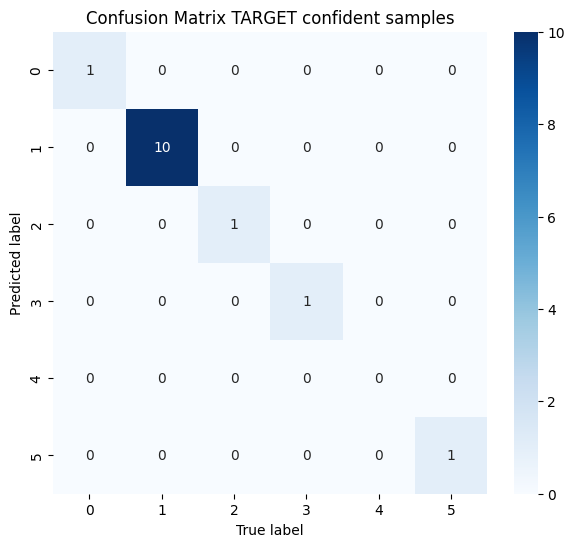

In [27]:
# Generate pseudo-labels for the target dataset
Xt_confident, Yt_confident, Xt_confident_indices = generate_pseudo_labels(model_GAN_custom_loss, Xt_test,0.9)

# Calculate the accuracy of the model on the confident target samples
Yt_confident_cat = to_categorical(Yt_confident, num_classes=10)
pred_Yt_confident_probas, _ = model_GAN_custom_loss.predict(Xt_confident, verbose=0)
pred_Yt_confident = tf.argmax(pred_Yt_confident_probas, axis=1)
correct_pred_Yt_confident = tf.cast(tf.equal(pred_Yt_confident, Yt_confident), tf.float32)
accuracy_target_confident = tf.reduce_mean(correct_pred_Yt_confident).numpy()
print('Accuracy on confident target samples:', round(accuracy_target_confident*100, 2))

# Calculate the accuracy on the main task by label
confusion_mtx_target_confident = tf.math.confusion_matrix(pred_Yt_confident, Yt_confident)

# show confusion matrix
plt.figure(figsize=(7, 6)) 
sns.heatmap(confusion_mtx_target_confident, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix TARGET confident samples')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()



In [28]:
##############################################################################
# GENERATING THE NEW X_Train with pseudo labels, Y_main_task and Y_adversary
##############################################################################
# 1. Concatenate MNIST and SVHN_confident images
X_train_new = np.concatenate([Xs_train, Xt_confident], axis=0)

# 2. Create main task labels, with pseudo labels for SVHN
Y_main_task_new = np.concatenate([Ys_train_cat, Yt_confident_cat], axis=0)
print(Y_main_task_new.shape)

# 3. Create adversary labels (0 for MNIST, 1 for SVHN)
Ys_train_adversary = np.zeros((Ys_train.shape[0], 1))  # 0 for MNIST
Yt_confident_adversary = np.ones((Yt_confident.shape[0], 1))  # 1 for SVHN
Y_adversary_new = np.concatenate([Ys_train_adversary, Yt_confident_adversary], axis=0)
print(Y_adversary_new.shape)

# 4. Shuffle the combined dataset to ensure mixed samples of both domains
# Create an index tensor and shuffle it
indices_new = tf.range(start=0, limit=tf.shape(X_train_new)[0], dtype=tf.int32)
shuffled_indices_new = tf.random.shuffle(indices_new)

# 5. Use the shuffled indices to reorder the dataset
X_train_new = tf.gather(X_train_new, shuffled_indices_new)
Y_main_task_new = tf.gather(Y_main_task_new, shuffled_indices_new)
Y_adversary_new = tf.gather(Y_adversary_new, shuffled_indices_new)


(60014, 10)
(60014, 1)


In [29]:
################################################################
#  CREATE BATCHED DATASETS ON X_train, Y_main_task, Y_adversary
################################################################

# Create a TensorFlow dataset from the tensors
dataset_new = tf.data.Dataset.from_tensor_slices((X_train_new, {"main_task_output": Y_main_task_new, "adversarial_output": Y_adversary_new}))

# Batch the dataset
dataset_new = dataset_new.batch(batch_size)

# Optional: Add .prefetch to improve performance by overlapping the preprocessing and model execution of a batch
# For example, .prefetch(tf.data.AUTOTUNE) allows the dataset to automatically tune the prefetch buffer size
dataset_new = dataset_new.prefetch(tf.data.AUTOTUNE)

In [30]:
#################################################################
# TRAINING A SIMPLIST GAN (image size 28x28) ON PSEUDO LABELS
# inspired by the classical LeNet-5 (LeCun et al., 1998)
#################################################################

# define input dimension
input_dim = (28,28,1)

# Input layer
input_layer = Input(shape=(input_dim))

# Deep feature extractor = features f
feature_extractor = Conv2D(32, (5, 5), activation='relu', input_shape=(28,28,1))(input_layer)  #size (24,24,32)
feature_extractor = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(feature_extractor)          #size (12,12,32)
feature_extractor = Conv2D(48, (5, 5), activation='relu')(feature_extractor)                   #size (8,8,48)
feature_extractor = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(feature_extractor)          #size (4,4,48)
extracted_features = Flatten()(feature_extractor)                                              #size 768

# Label predictor (Main task classifier layers)
# multi-class classification (10 classes from 0 to 9)
main_task_hidden = Dense(100, activation='relu')(extracted_features)
main_task_hidden = Dense(100, activation='relu')(main_task_hidden)
main_task_output = Dense(10, activation='softmax', name='main_task_output')(main_task_hidden)

# Domain classifier (Adversarial component layers)
# binary classification (MNIST=0 and SVHN=1) 
gradient_reversal = GradientReversalLayer(alpha=0.01)(extracted_features)
adversary_hidden = Dense(100, activation='relu')(gradient_reversal)
adversarial_output = Dense(1, activation='sigmoid', name='adversarial_output')(adversary_hidden)

# Model
model_GAN_pseudo_label_1 = Model(inputs=input_layer, outputs=[main_task_output, adversarial_output])

model_GAN_pseudo_label_1.compile(optimizer='adam',
                  loss={'main_task_output': CategoricalCrossentropy(),  # Categorical crossentropy loss on all samples (MNIST pseudo labelled SVHN)
                        'adversarial_output': BinaryCrossentropy()}, # Binary crossentropy loss on all samples
                  metrics={'main_task_output': ['accuracy'], 'adversarial_output': ['accuracy']} #AUC() not supported in custom loss functions
                  )

# % MNIST vs SVHN
print('% MNIST in sample (=adversarial target):',round(1 - np.mean(Y_adversary_new.numpy()),2))
# Train the model
history_pseudo_label_1 = model_GAN_pseudo_label_1.fit(dataset_new, batch_size=batch_size, epochs=3)

% MNIST in sample (=adversarial target): 1.0
Epoch 1/3
1876/1876 [==============================] - 31s 9ms/step - loss: 0.1433 - main_task_output_loss: 0.1396 - adversarial_output_loss: 0.0037 - main_task_output_accuracy: 0.9570 - adversarial_output_accuracy: 0.9993
Epoch 2/3
1876/1876 [==============================] - 18s 10ms/step - loss: 0.0484 - main_task_output_loss: 0.0474 - adversarial_output_loss: 0.0010 - main_task_output_accuracy: 0.9852 - adversarial_output_accuracy: 0.9998
Epoch 3/3
1876/1876 [==============================] - 20s 10ms/step - loss: 0.0324 - main_task_output_loss: 0.0317 - adversarial_output_loss: 7.1123e-04 - main_task_output_accuracy: 0.9899 - adversarial_output_accuracy: 0.9998


Source test dataset scores: [0.04207521677017212, 0.042021606117486954, 5.3624713473254815e-05, 0.9870793223381042, 1.0]
Accuracy on the main task (source): 98.71
Accuracy on the adversarial task (source): 100.0
Ys_test: [ 978 1133 1030 1009  980  888  958 1027  973 1008]


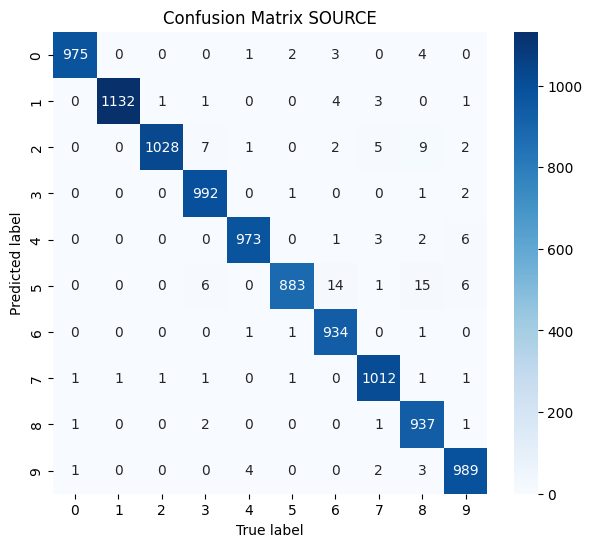

In [31]:
######################################################
# EVALUATE THE MODEL ON THE SOURCE TEST DATASET
######################################################

# Make predictions on the source test set
pred_Ys_test_scores = model_GAN_pseudo_label_1.evaluate(Xs_test,  {'main_task_output': Ys_test_cat, 'adversarial_output': Ys_test_adversary}, verbose=0)
print('Source test dataset scores:', pred_Ys_test_scores)

#Predictions
pred_Ys_test_probas, pred_Ys_test_probas_adversarial = model_GAN_pseudo_label_1.predict(Xs_test, verbose=0)
pred_Ys_test = tf.argmax(pred_Ys_test_probas, axis=1)
pred_Ys_test_adversarial = tf.argmax(pred_Ys_test_probas_adversarial, axis=1)
#print('probas pred_Ys_test[0]:',pred_Ys_test[0])
#print('labels pred_Ys_test[:10]:',pred_Ys_test[:10],type(pred_Ys_test))

# Accuracy scores main and adversarial tasks
correct_pred_Ys_test = tf.cast(tf.equal(pred_Ys_test, Ys_test), tf.float32)
accuracy_source_main_task = tf.reduce_mean(correct_pred_Ys_test).numpy()
print('Accuracy on the main task (source):', round(accuracy_source_main_task*100, 2))

correct_pred_Ys_test_adversarial = tf.cast( tf.equal(pred_Ys_test_adversarial, Ys_test_adversary)   , tf.float32)
accuracy_source_adversarial = tf.reduce_mean(correct_pred_Ys_test_adversarial).numpy()
print('Accuracy on the adversarial task (source):', round(accuracy_source_adversarial*100, 2))

# Calculate the accuracy on the main task by label
confusion_mtx_pseudo_label_1_source = tf.math.confusion_matrix(pred_Ys_test, Ys_test)

# print number of samples per label
print('Ys_test:',np.bincount(Ys_test))

# show confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mtx_pseudo_label_1_source, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix SOURCE')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [32]:
######################################################
# EVALUATE THE MODEL ON THE SOURCE TEST DATASET
######################################################

# Make predictions on the source test set
pred_Yt_test_scores = model_GAN_pseudo_label_1.evaluate(Xt_test,  {'main_task_output': Yt_test_cat, 'adversarial_output': Yt_test_adversary}, verbose=0)
print('Target test dataset scores:', pred_Yt_test_scores)

#Predictions
pred_Yt_test_probas, pred_Yt_test_probas_adversarial = model_GAN_pseudo_label_1.predict(Xt_test, verbose=0)
pred_Yt_test = tf.argmax(pred_Yt_test_probas, axis=1)
pred_Yt_test_adversarial = tf.argmax(pred_Yt_test_probas_adversarial, axis=1)

# Accuracy scores main and adversarial tasks
correct_pred_Yt_test = tf.cast(tf.equal(pred_Yt_test, Yt_test), tf.float32)
accuracy_target_main_task = tf.reduce_mean(correct_pred_Yt_test).numpy()
print('Accuracy on the main task (target):', round(accuracy_target_main_task*100, 2))

correct_pred_Yt_test_adversarial = tf.cast( tf.equal(pred_Yt_test_adversarial, Yt_test_adversary)   , tf.float32)
accuracy_target_adversarial = tf.reduce_mean(correct_pred_Yt_test_adversarial).numpy()
print('Accuracy on the adversarial task (target):', round(accuracy_target_adversarial*100, 2))

# Calculate the accuracy on the main task by label
confusion_mtx_pseudo_label_1_target = tf.math.confusion_matrix(pred_Yt_test, Yt_test)

# print number of samples per label
print('Yt_test:',np.bincount(Yt_test))

# show confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_mtx_pseudo_label_1_target, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix TARGET')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

Target test dataset scores: [3.103430986404419, 2.0396244525909424, 1.063807487487793, 0.31938037276268005, 0.05435116961598396]
Accuracy on the main task (target): 31.94


2024-04-01 11:07:14.141523: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (mklcpu) ran out of memory trying to allocate 2.52GiB (rounded to 2707329024)requested by op Cast
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-01 11:07:14.142595: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for mklcpu
2024-04-01 11:07:14.142614: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-04-01 11:07:14.142618: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-04-01 11:07:14.142621: I external/local_tsl/tsl/framework/b

ResourceExhaustedError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[26016,26016] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:Cast] name: 

**3/ ADVERSARIAL NEURAL NETWORK (KERAS), upscaling MNIST to SVHN dimension (32,32,3)**
---
"Domain-Adversarial Training of Neural Networks" Ganin & al, Journal of Machine Learning Research 17 (2016) 1-35

In [ ]:
# DUPLICATING MNIST IMAGES TO RGB (3 channels) AND RESIZING TO 32x32

def adapt_mnist_images(images):
    # Resize images from 28x28 to 32x32
    images_resized = tf.image.resize(images, [32, 32])
    # Convert grayscale images to RGB by repeating the channel 3 times
    images_rgb = tf.repeat(images_resized, 3, axis=-1)
    return images_rgb

# Assuming mnist_train_images and mnist_test_images are loaded MNIST datasets and normalized
# Example: Adapt the MNIST training images
mnist_train_images_adapted = adapt_mnist_images(mnist_train_images)
mnist_test_images_adapted = adapt_mnist_images(mnist_test_images)

print("Adapted MNIST Train Images Shape:", mnist_train_images_adapted.shape)
print("Adapted MNIST Test Images Shape:", mnist_test_images_adapted.shape)


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Create a figure and axes for the grid
fig, axes = plt.subplots(3, 10, figsize=(10, 3))

# Iterate over the first 30 images
for i, ax in enumerate(axes.flat):
    # Display the image
    ax.imshow(x_train[i], cmap='gray')
    ax.axis('off')
    # Set the title as the label
    ax.set_title(str(y_train[i]))

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of images
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a figure and axes for the grid
fig, axes = plt.subplots(3, 10, figsize=(10, 3))

# Iterate over the first 30 images
for i, ax in enumerate(axes.flat):
    # Get the image and label
    image, label = mnist_data[i]
    # Display the image
    ax.imshow(image.squeeze(), cmap='gray')
    ax.axis('off')
    # Set the title as the label
    ax.set_title(str(label.item()))

# Adjust the spacing between subplots
plt.tight_layout()

# Show the grid of images
plt.show()
